In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, OPTICS
from scipy.special import gamma
from collections import defaultdict
from itertools import product, combinations
import pickle
import networkx as nx
from tqdm import tqdm
import predictor

In [3]:
ROOT_PATH = 'D:/Jupyter/pred_tsyrenov'

n_train = 10_000
n_test = 1_000 + 300 # to get test set of 1000, 300 - про запас
n_passed = 3_000
n_valid = 2_000

with open(ROOT_PATH + '/lorenz.dat', 'rb') as f:
    Y = pickle.load(f)

Y1 = np.array(Y[n_passed:n_passed + n_train]).reshape(-1)
Y2 = np.array(Y[n_passed + n_train:n_passed + n_train + n_test]).reshape(-1)
Y3 = np.array(Y[n_passed + n_train + n_test:n_passed + n_train + n_test + n_valid]).reshape(-1)

In [4]:
class Wishart:
    def __init__(self, wishart_neighbors, significance_level):
        self.wishart_neighbors = wishart_neighbors  # Number of neighbors
        self.significance_level = significance_level  # Significance level

    def fit(self, X):
        from sklearn.neighbors import KDTree
        kdt = KDTree(X, metric='euclidean')

        distances, neighbors = kdt.query(X, k = self.wishart_neighbors + 1, return_distance = True)
        neighbors = neighbors[:, 1:]


        distances = distances[:, -1]
        indexes = np.argsort(distances)
        
        size, dim = X.shape

        self.object_labels = np.zeros(size, dtype = int) - 1

        self.clusters = np.array([(1., 1., 0)])
        self.clusters_to_objects = defaultdict(list)

        for index in indexes:
            neighbors_clusters =\
                np.concatenate([self.object_labels[neighbors[index]], self.object_labels[neighbors[index]]])
            unique_clusters = np.unique(neighbors_clusters).astype(int)
            unique_clusters = unique_clusters[unique_clusters != -1]


            if len(unique_clusters) == 0:
                self._create_new_cluster(index, distances[index])
            else:
                max_cluster = unique_clusters[-1]
                min_cluster = unique_clusters[0]
                if max_cluster == min_cluster:
                    if self.clusters[max_cluster][-1] < 0.5:
                        self._add_elem_to_exist_cluster(index, distances[index], max_cluster)
                    else:
                        self._add_elem_to_noise(index)
                else:
                    my_clusters = self.clusters[unique_clusters]
                    flags = my_clusters[:, -1]
                    if np.min(flags) > 0.5:
                        self._add_elem_to_noise(index)
                    else:
                        significan = np.power(my_clusters[:, 0], -dim) - np.power(my_clusters[:, 1], -dim)
                        significan *= self.wishart_neighbors
                        significan /= size
                        significan /= np.power(np.pi, dim / 2)
                        significan *= gamma(dim / 2 + 1)
                        significan_index = significan >= self.significance_level

                        significan_clusters = unique_clusters[significan_index]
                        not_significan_clusters = unique_clusters[~significan_index]
                        significan_clusters_count = len(significan_clusters)
                        if significan_clusters_count > 1 or min_cluster == 0:
                            self._add_elem_to_noise(index)
                            self.clusters[significan_clusters, -1] = 1
                            for not_sig_cluster in not_significan_clusters:
                                if not_sig_cluster == 0:
                                    continue

                                for bad_index in self.clusters_to_objects[not_sig_cluster]:
                                    self._add_elem_to_noise(bad_index)
                                self.clusters_to_objects[not_sig_cluster].clear()
                        else:
                            for cur_cluster in unique_clusters:
                                if cur_cluster == min_cluster:
                                    continue

                                for bad_index in self.clusters_to_objects[cur_cluster]:
                                    self._add_elem_to_exist_cluster(bad_index, distances[bad_index], min_cluster)
                                self.clusters_to_objects[cur_cluster].clear()

                            self._add_elem_to_exist_cluster(index, distances[index], min_cluster)

        return self.clean_data()

    def clean_data(self):
        unique = np.unique(self.object_labels)
        index = np.argsort(unique)
        if unique[0] != 0:
            index += 1
        true_cluster = {unq :  index for unq, index in zip(unique, index)}
        result = np.zeros(len(self.object_labels), dtype = int)
        for index, unq in enumerate(self.object_labels):
            result[index] = true_cluster[unq]
        return result

    def _add_elem_to_noise(self, index):
        self.object_labels[index] = 0
        self.clusters_to_objects[0].append(index)

    def _create_new_cluster(self, index, dist):
        self.object_labels[index] = len(self.clusters)
        self.clusters_to_objects[len(self.clusters)].append(index)
        self.clusters = np.append(self.clusters, [(dist, dist, 0)], axis = 0)

    def _add_elem_to_exist_cluster(self, index, dist, cluster_label):
        self.object_labels[index] = cluster_label
        self.clusters_to_objects[cluster_label].append(index)
        self.clusters[cluster_label][0] = min(self.clusters[cluster_label][0], dist)
        self.clusters[cluster_label][1] = max(self.clusters[cluster_label][1], dist)





def self_healing_window(train_array, heal_array, not_predictable_point_label = 'N'):
    healed_array = heal_array
    nnp_label = not_predictable_point_label

    n = len(train_array)
    k = len(heal_array)

    checked_windows = []

    for i in range(n - k):
        error = 0
        
        for j in range(k):
            if heal_array[j] != nnp_label:
                error += (train_array[i + j] - heal_array[j]) ** 2
        
        checked_windows.append([i, error])
    
    best_window = min(checked_windows, key = lambda x: x[1])

    for i in range(k):
        if heal_array[i] == nnp_label:
            heal_array[i] = train_array[i + best_window[0]]

    return healed_array










class predictor_markov_chain_gradient():
    def __init__(self):
        self.graph = None
        self.train_array = None
        self.max_pattern_len = None

    def fit_train_array(self, train_array):
        self.train_array = train_array

    def produce_graph(self, max_pattern_len = 100, round_ = 1, mode = 'ind'):
        
        if self.train_array.all() == None:
            raise ValueError('Train array is empty')

        if len(self.train_array) < max_pattern_len:
            raise ValueError('Max pattern length is greater than train array length')

        G = nx.DiGraph()
        n = len(self.train_array)
        G.add_node(0, grad = None, level = None)

        for i in range(n - max_pattern_len):
            current_node = 0

            for j in range(max_pattern_len - 2):
                grad = round(self.train_array[i + j] - 2 * self.train_array[i + j + 1] + self.train_array[i + j + 2], round_)

                if mode == 'uni':
                    current_level = [i for i in G.nodes if G.nodes[i]['level'] == j + 1]
                elif mode == 'ind':
                    current_level = [i for i in G.neighbors(current_node)]

                if grad not in [G.nodes[i]['grad'] for i in current_level]:
                    new_node = len(G)
                    G.add_node(new_node, grad = grad, level = j + 1)
                    G.add_edge(current_node, new_node, weight = 1)
                    current_node = new_node
            
                else:
                    correct_node = [i for i in current_level if G.nodes[i]['grad'] == grad][0]

                    if G.has_edge(current_node, correct_node):
                        G[current_node][correct_node]['weight'] += 1
                
                    else:
                        G.add_edge(current_node, correct_node, weight = 1)
                
                    current_node = correct_node
        
        self.graph = G
        self.max_pattern_len = max_pattern_len
        pass

    def get_graph(self):
        return self.graph
    
    def get_max_pattern_len(self):
        return self.max_pattern_len

    def get_trajectory(self, start_couple, trajectory_len, power = 1):

        if self.graph == None:
            raise ValueError('Graph not founded')

        if trajectory_len > self.max_pattern_len:
            raise ValueError('Trajectory length > Max possible trajectory lenght')

        trajectory = [start_couple[0], start_couple[1]]

        velocity = trajectory[0] - trajectory[1]
        current_y = trajectory[1]
        current_node = 0

        for i in range(trajectory_len - 3):
            
            weights = np.array([self.graph[current_node][i]['weight'] for i in self.graph.neighbors(current_node)]) ** power
            nodes = [i for i in self.graph[current_node]]
            weights = weights / weights.sum()

            next_node = np.random.choice(nodes, p = weights)
            velocity = velocity - self.graph.nodes[next_node]['grad']
            current_y = current_y - velocity
            trajectory.append(current_y)
            current_node = next_node

        return trajectory
    
    def continue_trajectory(self, trace, power = 1):
        trajectory = [trace[0], trace[1]]
        velocity = trace[0] - trace[1]
        current_node = 0

        for i in range(len(trace) - 2):
            grad = trace[i] - 2 * trace[i + 1] + trace[i + 2]
            nodes = [(i, self.graph.nodes[i]['grad']) for i in self.graph.neighbors(current_node)]
            error = [(i, np.sqrt(j - grad)) for i, j in nodes]
            next_node = min(error, key = lambda x: x[1])[0]

            velocity = velocity - self.graph.nodes[next_node]['grad']
            trajectory.append(trajectory[-1] - velocity)
            current_node = next_node
        
        for i in range(self.max_pattern_len - len(trace)):
            weights = np.array([self.graph[current_node][i]['weight'] for i in self.graph.neighbors(current_node)]) ** power
            nodes = [i for i in self.graph[current_node]]
            weights = weights / weights.sum()

            next_node = np.random.choice(nodes, p = weights)
            velocity = velocity - self.graph.nodes[next_node]['grad']
            trajectory.append(trajectory[-1] - velocity)
            current_node = next_node
        
        return trajectory

    def unified_prediction(self, possible_predictions, up_method, \
        random_perturbation=False, **kwargs):
        '''Calculates unified prediciton from set of possible predicted values

        Parameters
        ----------
        possible_predictions: list or 1D np.array
            List of possible predictions
        up_method: str from {'a', 'wi', 'db', 'op'}
            Method of estimating unified prediciton
            'a'  - average
            'wi' - clustering with Wishart, get largest cluster mean
            'db' - clustering with DBSCAN, get largest cluster mean
            'op' - clustering with OPTICS, get largest cluster mean
        random_perturbation: boolean
            Add noise to unified prediction

        **kwargs
        -- for Wishart, DBSCAN and OPTICS clustering --
        min_samples: int > 1 or float between 0 and 1, default=5
            Minimal number of samples in cluster
        eps: float from 0 to 1, default=0.01
            Max distance within one cluster
        cluster_size_threshold: float from 0 to 1, default=0.2
            Minimal percentage of points in largest cluster to call point predictable
        one_cluster_rule: boolean, defalut=False
            Point is predictable only is there is one cluster (not including noise)
        '''

        if len(possible_predictions) == 0:
            return 'N'
        min_samples = kwargs.get('min_samples', 5)
        eps = kwargs.get('eps', 0.01)

        if up_method == 'a':
            avg = np.mean(possible_predictions)
            if random_perturbation:
                avg += np.random.normal(0, 0.01)
            return avg

        if up_method == 'wi' or up_method == 'db' or up_method=='op':  
            try: 
                if up_method == 'db': 
                    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
                    labels = clustering.fit_predict(np.array(possible_predictions).reshape(-1, 1))
                    
                elif up_method == 'wi':
                    clustering = Wishart(min_samples, eps)
                    labels = clustering.fit(np.array(possible_predictions).reshape(-1, 1))
                    labels[labels == 0] = -1
                elif up_method == 'op':
                    clustering = OPTICS(max_eps=eps, min_samples=min_samples)
                    labels = clustering.fit_predict(np.array(possible_predictions).reshape(-1, 1))
            except:
                return 'N'
                
            threshold = kwargs.get('cluster_size_threshold', 0.2)
            one_cluster_rule = kwargs.get('one_cluster_rule', False)
            unique_labels, unique_counts = np.unique(labels, return_counts=True)
            unique_labels = zip(unique_labels, unique_counts)
            unique_labels = list(filter(lambda x: x[0] != -1, unique_labels))
            if len(unique_labels) == 0:
                return 'N'
            if one_cluster_rule and len(unique_labels) > 1:
                return 'N'
            x, y = map(list, zip(*unique_labels))
            max_count = max(y)
            if max_count / len(possible_predictions) < threshold:
                return 'N'

            max_cluster = list(filter(lambda x: x[1] == max_count, unique_labels))[0]
            
            avg = np.mean(possible_predictions[labels == max_cluster[0]])
            if random_perturbation:
                avg += np.random.normal(0, 0.01)
            return avg
        
    def predict(self, preceding_array, h, non_pred_model, up_method = 'a'):
        
        n = len(preceding_array)
        k = self.max_pattern_len - n

        start_i = 2
        if h > self.max_pattern_len - 3:
            raise ValueError('Horizon > max possible len of prediction')

        predictions = []
        possible_predictions = [[] for i in range(k + n - start_i - 1)]

        for i in range(start_i, self.max_pattern_len - max(k, 0)):
            
            pred_array = self.continue_trajectory(preceding_array[-i:])
            
            for j in range(len(pred_array[(start_i + i):])):

                possible_predictions[j].append(pred_array[(start_i + i):][j])
                
        for i in range(len(possible_predictions)):
            if non_pred_model.is_predictable(possible_predictions[i]):
                predictions.append(self.unified_prediction(possible_predictions[i], up_method))
            else:
                predictions.append('N')

        return predictions[:h], possible_predictions[:h]





class NonPredModel():
    def is_predictable(self, possible_predictions, **kwargs):
        pass
    
    def reset(self):
        pass

    def __str__(self):
        return self.__class__.__name__


class ForcedPredictionNPM(NonPredModel):
    def __init__(self):
        pass

    def is_predictable(self, possible_predictions):
        return True

    def __str__(self):
        return self.__class__.__name__

class RapidGrowthNPM(NonPredModel):
    def __init__(self):
        self.min_max_spreads = []

    def is_predictable(self, possible_predictions):
        if len(possible_predictions) == 0:
            return False
        current_spread = max(possible_predictions) - min(possible_predictions)
        self.min_max_spreads.append(current_spread)
        self.min_max_spreads = self.min_max_spreads[-4:]
        if len(self.min_max_spreads) < 4:
            return True
        if self.min_max_spreads[0] < self.min_max_spreads[1] \
            and self.min_max_spreads[1] < self.min_max_spreads[2] \
                and self.min_max_spreads[2] < self.min_max_spreads[3]:
            return False
        else:
            return True
    
    def reset(self):
        self.min_max_spreads = []

    def __str__(self):
        return self.__class__.__name__


class RapidGrowthDBSCANNPM(NonPredModel):
    def __init__(self, min_samples=5, eps=0.01):
        self.dbscan_spreads = []
        self.min_samples = min_samples
        self.eps = eps

    def is_predictable(self, possible_predictions):
        if len(possible_predictions) == 0:
            return False
        dbscan = DBSCAN(min_samples=self.min_samples, eps=self.eps)
        try:
            labels = dbscan.fit_predict(np.array(possible_predictions).reshape(-1, 1))
        except:
            labels = [-1]
        unique_clusters = np.unique(labels)
        self.dbscan_spreads.append(len(unique_clusters))
        self.dbscan_spreads = self.dbscan_spreads[-4:]
        if len(unique_clusters) == 1 and -1 in unique_clusters:
            return False
        if len(self.dbscan_spreads) < 4:
            return True
        if self.dbscan_spreads[0] < self.dbscan_spreads[1] \
            and self.dbscan_spreads[1] < self.dbscan_spreads[2] \
                and self.dbscan_spreads[2] < self.dbscan_spreads[3]\
                    and self.dbscan_spreads[3] > 2:
            return False
        else:
            return True

    def reset(self):
        self.dbscan_spreads = []

    def __str__(self):
        return self.__class__.__name__


class RapidGrowthWishartNPM(NonPredModel):
    def __init__(self, min_samples=5, eps=0.01):
        self.wishart_spreads = []
        self.min_samples = min_samples
        self.eps = eps

    def is_predictable(self, possible_predictions):
        if len(possible_predictions) == 0:
            return False
        wishart = Wishart(self.min_samples, self.eps)
        try:
            labels = wishart.fit(np.array(possible_predictions).reshape(-1, 1))
        except:
            labels = [0] 
        unique_clusters = np.unique(labels)
        self.wishart_spreads.append(len(unique_clusters))
        self.wishart_spreads = self.wishart_spreads[-4:]
        if len(unique_clusters) == 1 and 0 in unique_clusters:
            return False
        if len(self.wishart_spreads) < 4:
            return True
        if self.wishart_spreads[0] < self.wishart_spreads[1] \
            and self.wishart_spreads[1] < self.wishart_spreads[2] \
                and self.wishart_spreads[2] < self.wishart_spreads[3]\
                    and self.wishart_spreads[3] > 2:
            return False
        else:
            return True

    def reset(self):
        self.wishart_spreads = []

    def __str__(self):
        return self.__class__.__name__

class LimitClusterSizeNPM(NonPredModel):
    def __init__(self, min_cluster_size, max_n_clusters):
        self.min_cluster_size = min_cluster_size
        self.max_n_clusters = max_n_clusters


    def is_predictable(self, possible_predictions):
        dbscan = DBSCAN(eps=0.01, min_samples=5)
        try:
            labels = dbscan.fit_predict(np.array(possible_predictions).reshape(-1, 1))
        except:
            return False
        unique_labels, unique_counts = np.unique(labels, return_counts=True)
        unique_labels = zip(unique_labels, unique_counts)
        unique_labels = list(filter(lambda x: x[0] != -1, unique_labels))
        if len(unique_labels) == 0:
            return False
        if len(unique_labels) > self.max_n_clusters:
            return False
        x, y = map(list, zip(*unique_labels))
        max_count = max(y)
        if max_count / len(possible_predictions) < self.min_cluster_size:
            return False
        return True

    def __str__(self):
        return self.__class__.__name__ + '(min_cluster_size=' + \
            str(self.min_cluster_size) + ', max_n_clusters=' + \
            str(self.max_n_clusters) + ')'


In [5]:
class predictor_markov_chain():
    '''
    Class for time series predict
    Algorithm to start:
       -> Create a class
       -> Fit train array with fit_train_array
       -> Produce a graph with produce_graph
       -> Produce a predict with predict
    Attributes:
    ---------------------------
    graph : networkx graph
        Trained and used for predictions
    train_array : list of size len(list)
        List or array is used to train graph
    max_pattern_len : int
        Max possible length for array which is produced from predictor
    '''

    def __init__(self):
        self.graph = None
        self.train_array = None
        self.max_pattern_len = None

    def fit_train_array(self, train_array):
        self.train_array = train_array

    def produce_graph(self, max_pattern_len = 100, round_ = 1, mode = 'ind'):

        if self.train_array.all() == None:
            raise ValueError('Train array is empty')

        if len(self.train_array) < max_pattern_len:
            raise ValueError('Max pattern length is greater than train array length')

        G = nx.DiGraph()
        n = len(self.train_array)
        G.add_node(0, diff = None, level = 0)

        for i in tqdm(range(n - max_pattern_len)):
            current_node = 0

            for j in range(max_pattern_len - 1):
                diff = round(self.train_array[i + j] - self.train_array[i + j + 1], round_)

                if mode == 'uni':
                    current_level = [i for i in G.nodes if G.nodes[i]['level'] == j + 1]
                elif mode == 'ind':
                    current_level = [i for i in G.neighbors(current_node)]

                if diff not in [G.nodes[i]['diff'] for i in current_level]:
                    new_node = len(G)
                    G.add_node(new_node, diff = diff, level = j + 1)
                    G.add_edge(current_node, new_node, weight = 1)
                    current_node  = new_node
                
                else:
                    correct_node = [i for i in current_level if G.nodes[i]['diff'] == diff][0]
                    
                    if G.has_edge(current_node, correct_node):
                        G[current_node][correct_node]['weight'] += 1
                    
                    else:
                        G.add_edge(current_node, correct_node, weight = 1)

                    if G.nodes[correct_node]['level'] - G.nodes[current_node]['level'] != 1:
                        raise IndexError()
                        
                    current_node = correct_node

    
        self.graph = G
        self.max_pattern_len = max_pattern_len
        pass

    def get_graph(self):
        return self.graph
    
    def get_max_pattern_len(self):
        return self.max_pattern_len

    def set_graph(self, graph, max_pattern_len):
        self.graph = graph
        self.max_pattern_len = max_pattern_len
        pass
    
    def get_trajectory(self,start_y, trajectory_len, power = 1):

        if self.graph == None:
            raise ValueError('Graph not founded')

        if trajectory_len > self.max_pattern_len:
            raise ValueError('Trajectory length > Max possible trajectory lenght')

        current_node = 0
        current_y = start_y
        trajectory = [start_y]

        for i in range(trajectory_len - 2):

            weights = np.array([self.graph[current_node][i]['weight'] for i in self.graph.neighbors(current_node)]) ** power
            nodes = [i for i in self.graph[current_node]]
            weights = weights / weights.sum()

            if np.array(weights).sum() == 0:
                return trajectory

            next_node = np.random.choice(nodes, p = weights)
            current_y = current_y - self.graph.nodes[next_node]['diff']
            trajectory.append(current_y)
            current_node = next_node
            
        return trajectory

    def continue_trajectory(self, trace, power = 1):
        trajectory = [trace[0]]
        current_node = 0

        for i in range(len(trace) - 1):
            diff = trace[i] - trace[i + 1]
            nodes = [(i, self.graph.nodes[i]['diff']) for i in self.graph.neighbors(current_node)]
            error = [(i, np.sqrt((j - diff) ** 2)) for i, j in nodes]
            next_node = min(error, key = lambda x: x[1])[0]

            trajectory.append(trajectory[i] - self.graph.nodes[next_node]['diff'])
            current_node = next_node
        
        current_y = trajectory[-1]

        for i in range(self.max_pattern_len - len(trace)):
            
             weights = np.array([self.graph[current_node][i]['weight'] for i in self.graph.neighbors(current_node)]) ** power
             nodes = [i for i in self.graph[current_node]]
             weights = weights / weights.sum()

             next_node = np.random.choice(nodes, p = weights)
             current_y = current_y - self.graph.nodes[next_node]['diff']
             trajectory.append(current_y)
             current_node = next_node
            
        return trajectory

    def unified_prediction(self, possible_predictions, up_method, \
        random_perturbation=False, **kwargs):
        '''Calculates unified prediciton from set of possible predicted values

        Parameters
        ----------
        possible_predictions: list or 1D np.array
            List of possible predictions
        up_method: str from {'a', 'wi', 'db', 'op'}
            Method of estimating unified prediciton
            'a'  - average
            'wi' - clustering with Wishart, get largest cluster mean
            'db' - clustering with DBSCAN, get largest cluster mean
            'op' - clustering with OPTICS, get largest cluster mean
        random_perturbation: boolean
            Add noise to unified prediction

        **kwargs
        -- for Wishart, DBSCAN and OPTICS clustering --
        min_samples: int > 1 or float between 0 and 1, default=5
            Minimal number of samples in cluster
        eps: float from 0 to 1, default=0.01
            Max distance within one cluster
        cluster_size_threshold: float from 0 to 1, default=0.2
            Minimal percentage of points in largest cluster to call point predictable
        one_cluster_rule: boolean, defalut=False
            Point is predictable only is there is one cluster (not including noise)
        '''

        if len(possible_predictions) == 0:
            return 'N'
        min_samples = kwargs.get('min_samples', 5)
        eps = kwargs.get('eps', 0.01)

        if up_method == 'a':
            avg = np.mean(possible_predictions)
            if random_perturbation:
                avg += np.random.normal(0, 0.01)
            return avg

        if up_method == 'wi' or up_method == 'db' or up_method=='op':  
            try: 
                if up_method == 'db': 
                    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
                    labels = clustering.fit_predict(np.array(possible_predictions).reshape(-1, 1))
                    
                elif up_method == 'wi':
                    clustering = Wishart(min_samples, eps)
                    labels = clustering.fit(np.array(possible_predictions).reshape(-1, 1))
                    labels[labels == 0] = -1
                elif up_method == 'op':
                    clustering = OPTICS(max_eps=eps, min_samples=min_samples)
                    labels = clustering.fit_predict(np.array(possible_predictions).reshape(-1, 1))
            except:
                return 'N'
                
            threshold = kwargs.get('cluster_size_threshold', 0.2)
            one_cluster_rule = kwargs.get('one_cluster_rule', False)
            unique_labels, unique_counts = np.unique(labels, return_counts=True)
            unique_labels = zip(unique_labels, unique_counts)
            unique_labels = list(filter(lambda x: x[0] != -1, unique_labels))
            if len(unique_labels) == 0:
                return 'N'
            if one_cluster_rule and len(unique_labels) > 1:
                return 'N'
            x, y = map(list, zip(*unique_labels))
            max_count = max(y)
            if max_count / len(possible_predictions) < threshold:
                return 'N'

            max_cluster = list(filter(lambda x: x[1] == max_count, unique_labels))[0]
            
            avg = np.mean(np.array(possible_predictions)[labels == max_cluster[0]])
            if random_perturbation:
                avg += np.random.normal(0, 0.01)
            return avg
        
    def predict(self, preceding_array, h, non_pred_model, up_method = 'db', **kwargs):
        
        n = len(preceding_array)
        k = self.max_pattern_len - n

        start_i = 1
        if h > self.max_pattern_len - 2:
            raise ValueError('Horizon > max possible len of prediction')


        predictions = []
        possible_predictions = [[] for i in range(k + n - start_i - 1)]

        weight = kwargs.get('weight', 5)
        repeat = kwargs.get('repeat', 1)

        for i in range(start_i, self.max_pattern_len - max(k, 0)):

            for _ in range((i // weight + 1) * repeat):
            
                 pred_array = self.continue_trajectory(preceding_array[-i:])
            
                 for j in range(len(pred_array[(start_i + i):])):

                     possible_predictions[j].append(pred_array[(start_i + i):][j])
                
        for i in range(len(possible_predictions)):
            if non_pred_model.is_predictable(possible_predictions[i]):
                predictions.append(self.unified_prediction(possible_predictions[i], up_method, random_perturbation=False, **kwargs))
            else:
                predictions.append('N')

        return predictions[:h], possible_predictions[:h]

In [19]:
pre1 = predictor_markov_chain()
pre1.fit_train_array(Y1)
pre1.produce_graph(52, round_=2, mode='ind')
P = pre1.get_graph()

100%|██████████| 9898/9898 [00:10<00:00, 945.43it/s] 


In [66]:
non_pred_model = ForcedPredictionNPM()

In [9]:

kwargs = {
    'min_samples': 5,
    'eps' : 0.01,
    'cluster_size_threshold' : 0.1,
    'one_cluster_rule' : False,
    'weight' : 1,
    'repeat' : 2
}

y1, py1 = pre1.predict(Y2[:50], 10, non_pred_model, up_method='a', **kwargs)

In [29]:
pre2 = predictor.TimeSeriesPredictor([], non_pred_model)
cm = pre2.cluster_motifs(Y1)

In [30]:
prediction_params = {
    'up_method' : 'a', # {'a', 'wi', 'db', 'op'}
    'eps' : 0.01, # max distance in cluster
    'min_samples' : 5, # min number of samples in cluster
    'alg_type' : 's', # {'s', 'tp'}
    'np_method' : 'fp'
}

y2, py2 = pre2.predict(Y2[:30], 8, **prediction_params)

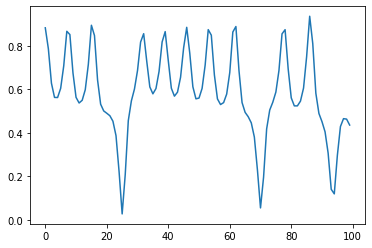

In [12]:
lst = [i for i in range(100)]
lst_y = Y2[:100]

plt.plot(lst, lst_y)

<AxesSubplot:>

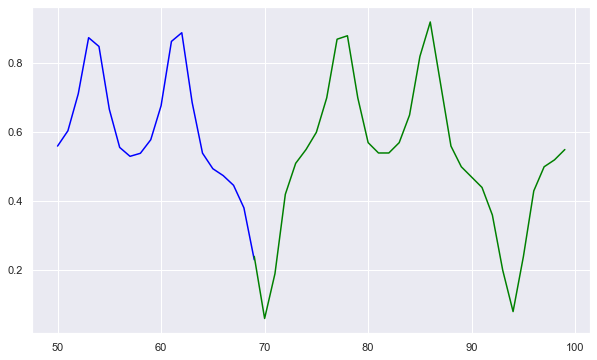

In [306]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

test_y = pre1.continue_trajectory(lst_y[50:70])[:50]

sns.lineplot(x=lst[50:70], y=lst_y[50:70], color='blue', ax=ax)
sns.lineplot(x=lst[69:100], y=test_y[19:], color='green', ax=ax)

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

def clean(x_array, y_array):
    x = []
    y = []
    for i, j in zip(x_array, y_array):
        if j != 'N':
            x.append(i)
            y.append(j)
    return x, y

In [ ]:
mse = []
mape = []
pnp = []

non_pred_model = ForcedPredictionNPM()
x = list(range(500, 600))
np.random.seed(574)
pre2.set_non_pred_model(non_pred_model)

prediction_params = {
    'up_method' : 'db', # {'a', 'wi', 'db', 'op'}
    'eps' : 0.01, # max distance in cluster
    'min_samples' : 5, # min number of samples in cluster
    'alg_type' : 's', # {'s', 'tp'}
    'np_method' : 'fp'
}

kwargs = {
    'min_samples': 5,
    'eps' : 0.01,
    'cluster_size_threshold' : 0.1,
    'one_cluster_rule' : False,
    'weight' : 1,
    'repeat' : 1
}

for i in tqdm(range(1, 100)):
    y1, py_1 = pre1.predict(Y2[400:500], i, non_pred_model, up_method='db', **kwargs)
    y2, py_1 = pre2.predict(Y2[400:500], i, **prediction_params)

    #x_1, y_1 = clean(x, y1)
    #x_2, y_2 = clean(x, y2)

    x_1 = []
    x_2 = []
    y_1 = []
    y_2 = []

    x_11, y_11 = clean(x, y1)

    for j in range(len(y1)):
        if y1[j] != 'N' and y2[j] != 'N':
            x_1.append(x[j])
            y_1.append(y1[j])
            y_2.append(y2[j])
    
    x_2 = x_1

    try:
        mse.append((mean_squared_error(np.array(Y2)[x_1], y_1), mean_squared_error(np.array(Y2)[x_2], y_2)))
        mape.append((mean_absolute_percentage_error(np.array(Y2)[x_1], y_1), mean_absolute_percentage_error(np.array(Y2)[x_2], y_2)))
        pnp.append(((len(y1) - len(y_11)) / len(y1), (len(y2) - len(y_2)) / len(y2)))
    except ValueError:
        print(i)

<AxesSubplot:>

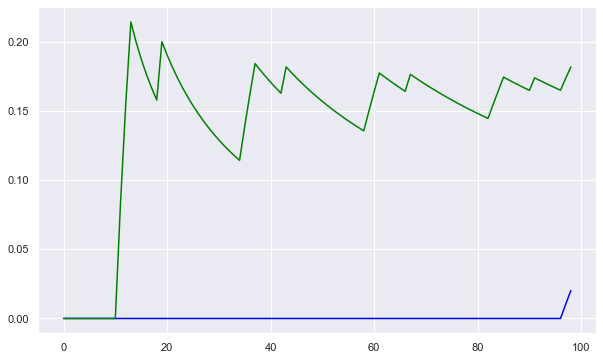

In [278]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

mse1 = []
mse2 = []

abc = pnp

for i in abc:
    mse1.append(i[0])
    mse2.append(i[1])

x = list(range(len(abc)))

sns.lineplot(x=x, y=mse1, color='blue', ax=ax)
sns.lineplot(x=x, y=mse2, color='green', ax=ax)

In [69]:
minn = 100

for i in tqdm(range(100)):
    seed_ = np.random.randint(0, 10000)
    np.random.seed(seed_)

    y3, py3 = pre1.predict(Y2[400:500], 20, non_pred_model, up_method='db', **kwargs)
    y4, py4 = pre1.predict(Y2[400:500], 50, non_pred_model, up_method='db', **kwargs)
    y5, py5 = pre1.predict(Y2[400:500], 80, non_pred_model, up_method='db', **kwargs)

    x_3, y_3 = clean(x, y3)
    x_4, y_4 = clean(x, y4)
    x_5, y_5 = clean(x, y5)

    mse3 = mean_squared_error(np.array(Y2)[x_3], y_3)
    mse4 = mean_squared_error(np.array(Y2)[x_4], y_4)
    mse5 = mean_squared_error(np.array(Y2)[x_5], y_5)

    if np.mean([mse3, mse4, mse5]) < minn:
        seed_min = seed_

100%|██████████| 100/100 [45:56<00:00, 27.56s/it]


In [122]:
sns.set_theme()

In [208]:
colum = ['x', 'y', 'up_method', 'method', 'size']

df = pd.DataFrame(columns=colum)
x = list(range(50))
for i in range(len(x)):
    df.loc[len(df)] = [x[i], Y2[i], 'true', 'Markov_Chain', 0]
    df.loc[len(df)] = [x[i], Y2[i], 'true', 'Clustering', 0]

In [ ]:
asd = 'wi'

prediction_params = {
    'up_method' : asd, # {'a', 'wi', 'db', 'op'}
    'eps' : 0.01, # max distance in cluster
    'min_samples' : 5, # min number of samples in cluster
    'alg_type' : 's', # {'s', 'tp'}
    'np_method' : 'fp'
}

for i in tqdm(range(1)):
    y1, py1 = pre1.predict(Y2[:20], 32, non_pred_model, up_method=asd, **kwargs)
    y2, py2 = pre2.predict(Y2[:20], 30, **prediction_params)

    x_1, y_1 = clean(x[20:], y1)
    x_2, y_2 = clean(x[20:], y2)

    for j in range(len(x_1)):
        df.loc[len(df)] = [x_1[j], y_1[j], asd, 'Markov_Chain', i]

    for j in range(len(x_2)):
        df.loc[len(df)] = [x_2[j], y_2[j], asd, 'Clustering', i]

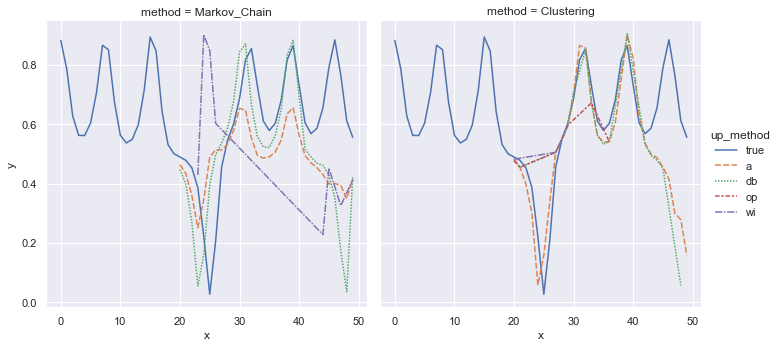

In [214]:
sns.relplot(
    data = df, kind = "line",
    x = 'x', y = 'y', col = 'method',
    hue = 'up_method', style = 'up_method',
)

In [220]:
len(y1)

20

In [221]:
df_max_mse = pd.DataFrame(columns=['max_n_clusters', 'max_mse', 'eps'])
x = list(range(50, 100))

for i, j in product([0.005, 0.01, 0.05, 0.1, 0.5], list(range(10))):
    y1, py1 = pre1.predict(Y2[:50], 20, RapidGrowthDBSCANNPM(j, i))
    x_1, y_1 = clean(x, y1)

    if len(y_1) > 0:
        df_max_mse.loc[len(df_max_mse)] = [j, np.max(np.sqrt((np.array(Y2)[x_1] - y_1) ** 2)), i]

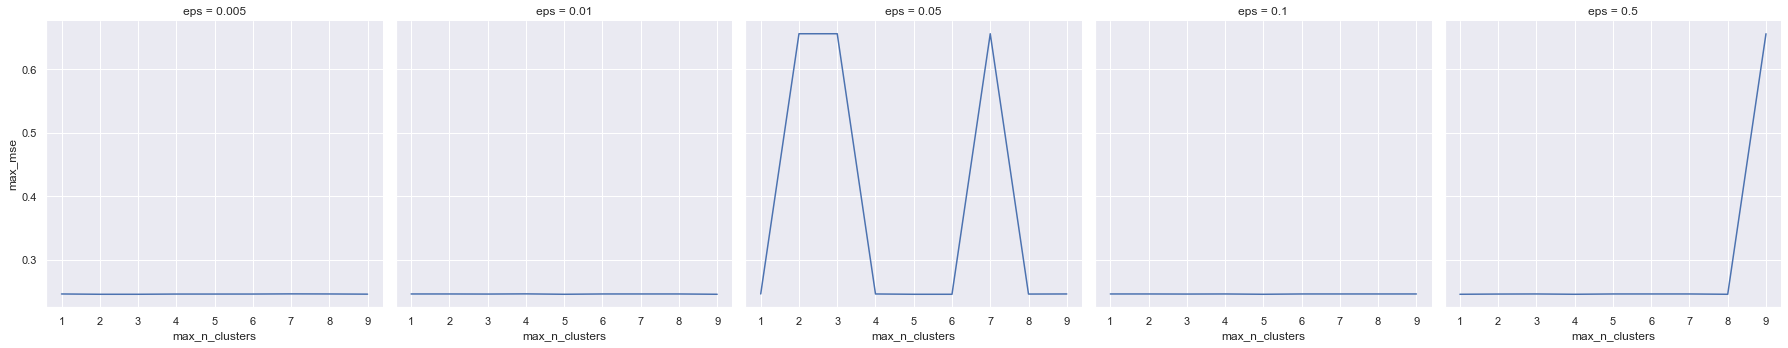

In [222]:
sns.relplot(
    data = df_max_mse, kind = "line",
    x = 'max_n_clusters', y = 'max_mse', col = 'eps',
)

In [26]:

df_traj = pd.DataFrame(columns=['x', 'y', 'horizon', 'graphic'])
x_start = 400
x = list(range(x_start, x_start + 100))
for i in range(100):
    df_traj.loc[len(df_traj)] = [x[i], Y2[x[i]], 'True', 'True and predicted points']

for i in tqdm(range(10)):
    y1, py1 = pre1.predict(Y2[:x_start], 10 * (i + 1), RapidGrowthNPM(), up_method='db', **kwargs)

    x_1, y_1 = clean(x, y1)

    for j in range(len(y_1)):
        df_traj.loc[len(df_traj)] = [x_1[j], y_1[j], 10 * (i + 1), 'True and predicted points']
    
    if len(y_1) > 0:
    
        df_traj.loc[len(df_traj)] = [10 * (i + 1), mean_squared_error(np.array(Y2)[x_1], y_1), 'True', 'RMSE']
        df_traj.loc[len(df_traj)] = [10 * (i + 1), mean_absolute_percentage_error(np.array(Y2)[x_1], y_1), 'True', 'MAPE']
        df_traj.loc[len(df_traj)] = [10 * (i + 1), (len(y1) - len(y_1)) / len(y1), 'True', 'Percentage of non-predictable points']

100%|██████████| 10/10 [03:09<00:00, 18.91s/it]


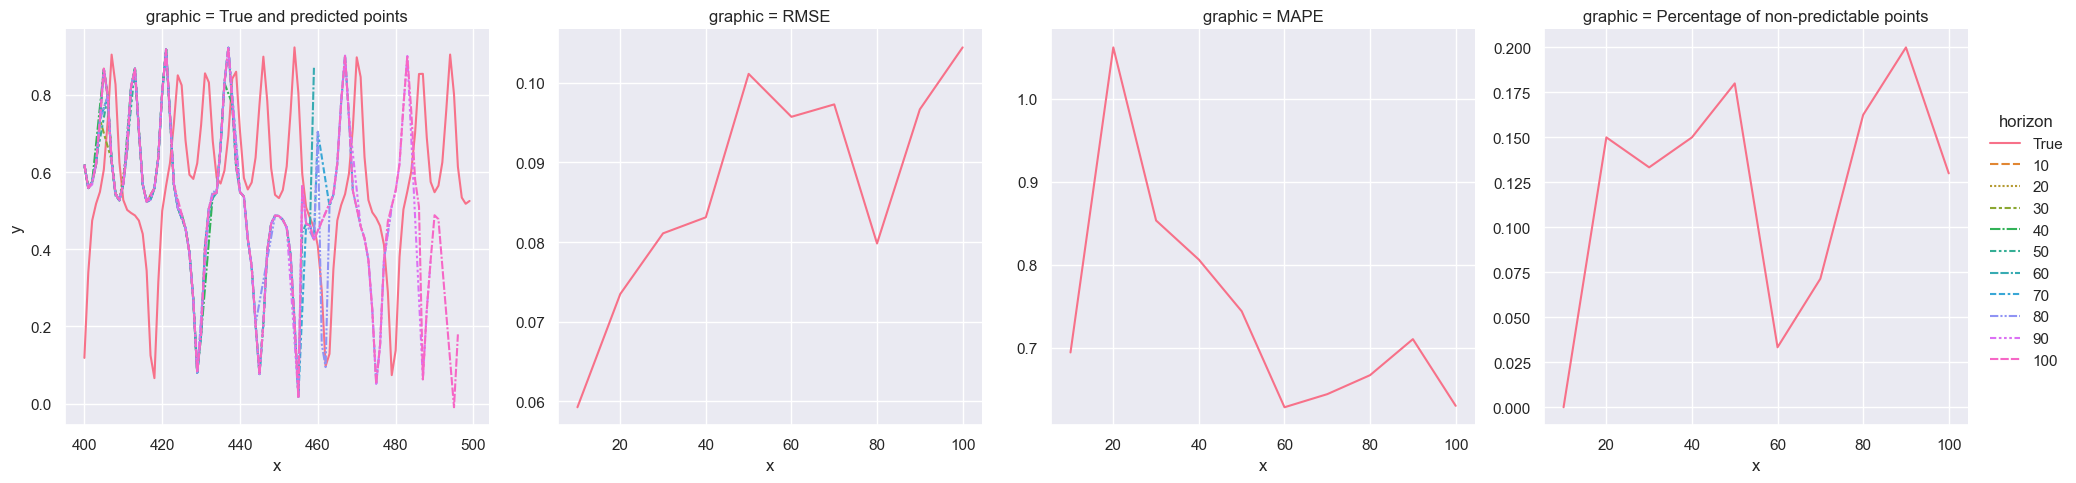

In [27]:
sns.set(rc={'figure.figsize':(15.7,12.27)})

sns.relplot(
    data = df_traj, kind = "line", col = 'graphic',
    x = 'x', y = 'y', hue='horizon', style='horizon', facet_kws=dict(sharex=False, sharey=False)
)

In [33]:
df_dif = pd.DataFrame(columns=['h', 'y', 'graphic', 'method'])

for i in range(len(mse)):
    df_dif.loc[len(df_dif)] = [i, mse[i][0], 'RMSE', 'Markov_Chain']
    df_dif.loc[len(df_dif)] = [i, mse[i][1], 'RMSE', 'Clustering']
    df_dif.loc[len(df_dif)] = [i, mape[i][0], 'MAPE', 'Markov_Chain']
    df_dif.loc[len(df_dif)] = [i, mape[i][1], 'MAPE', 'Clustering']
    df_dif.loc[len(df_dif)] = [i, pnp[i][0], 'Percentage of non-predictable points', 'Markov_Chain']
    df_dif.loc[len(df_dif)] = [i, pnp[i][1], 'Percentage of non-predictable points', 'Clustering']
    

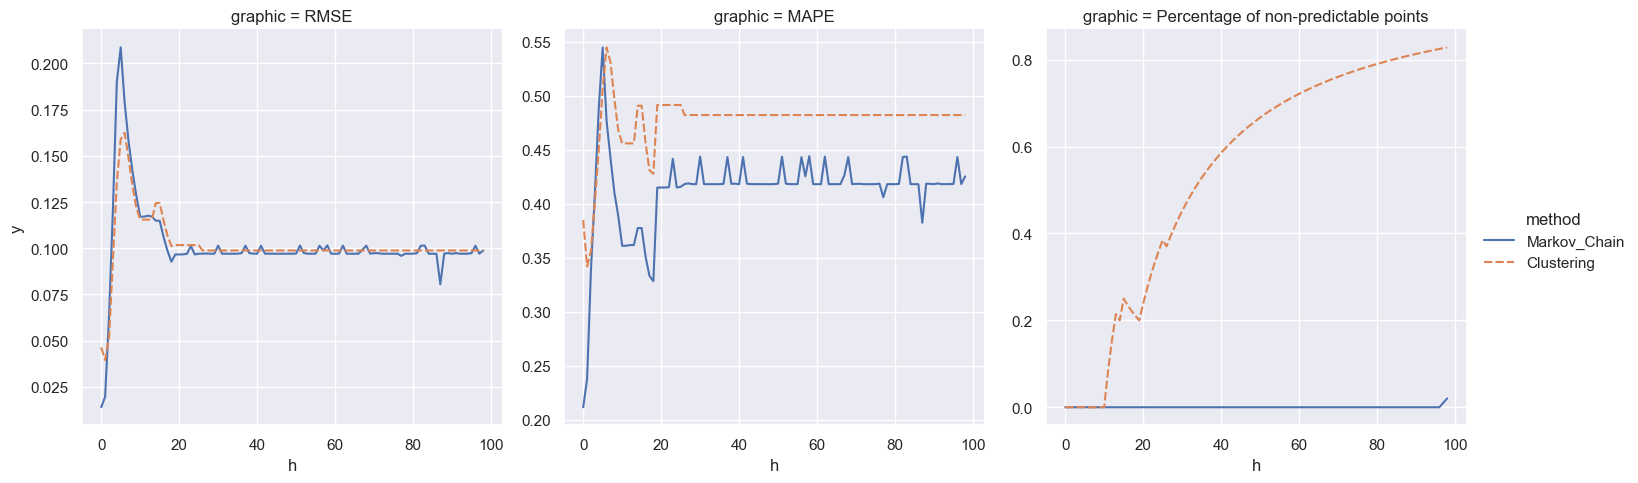

In [34]:
sns.set(rc={'figure.figsize':(15.7,12.27)})

sns.relplot(
    data = df_dif, kind = "line", col = 'graphic',
    x = 'h', y = 'y', hue='method', style='method', facet_kws=dict(sharey=False)
)

<AxesSubplot:>

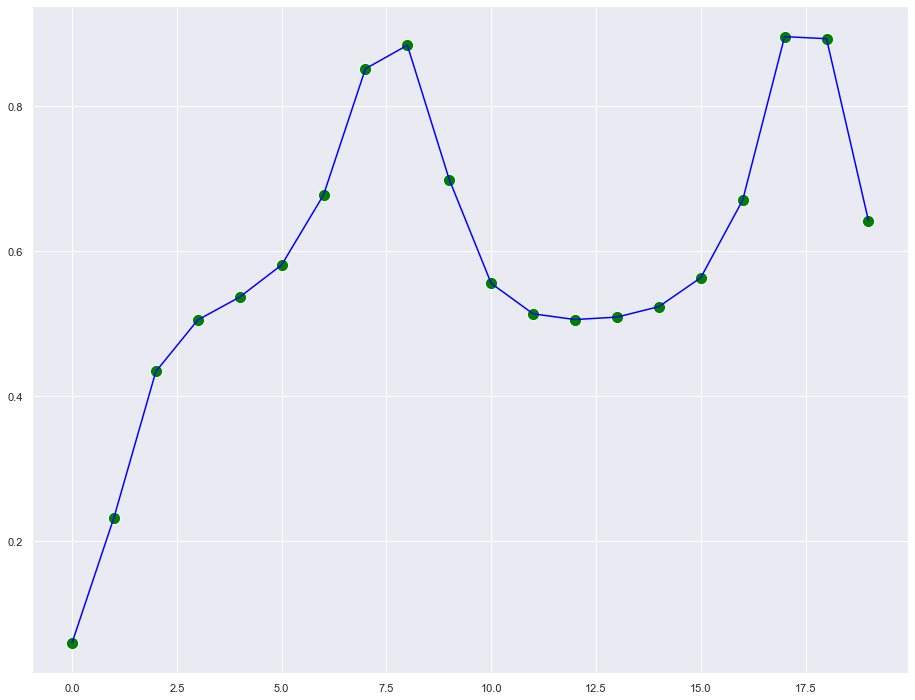

In [301]:
x = list(range(20))
y = np.array(Y1[:20])

sns.lineplot(x=x, y=y, color='blue')
sns.scatterplot(x=x, y=y, color='green', s=150)

In [ ]:
df_up = pd.DataFrame(columns=['h', 'y', 'graphic', 'algotithm'])
x = list(range(50, 100))

for i in tqdm(range(1, 50)):
    y1, py1 = pre1.predict(Y2[:50], i, ForcedPredictionNPM(), 'a', **kwargs)
    y2, py2 = pre1.predict(Y2[:50], i, ForcedPredictionNPM(), 'db', **kwargs)
    y3, py3 = pre1.predict(Y2[:50], i, ForcedPredictionNPM(), 'op', **kwargs)
    y4, py4 = pre1.predict(Y2[:50], i, ForcedPredictionNPM(), 'wi', **kwargs)

    x_1, y_1 = clean(x, y1)
    x_2, y_2 = clean(x, y2)
    x_3, y_3 = clean(x, y3)
    x_4, y_4 = clean(x, y4)

    if len(y_1) > 0 and len(y_2) > 0 and len(y_3) > 0 and len(y_4) > 0:
        df_up.loc[len(df_up)] = [i, mean_squared_error(np.array(Y2[:200][x_1]), y_1), 'RMSE', 'a']
        df_up.loc[len(df_up)] = [i, mean_squared_error(np.array(Y2[:200][x_2]), y_2), 'RMSE', 'db']
        df_up.loc[len(df_up)] = [i, mean_squared_error(np.array(Y2[:200][x_3]), y_3), 'RMSE', 'op']
        df_up.loc[len(df_up)] = [i, mean_squared_error(np.array(Y2[:200][x_4]), y_4), 'RMSE', 'wi']

        df_up.loc[len(df_up)] = [i, mean_absolute_percentage_error(np.array(Y2[:200][x_1]), y_1), 'MAPE', 'a']
        df_up.loc[len(df_up)] = [i, mean_absolute_percentage_error(np.array(Y2[:200][x_2]), y_2), 'MAPE', 'db']
        df_up.loc[len(df_up)] = [i, mean_absolute_percentage_error(np.array(Y2[:200][x_3]), y_3), 'MAPE', 'op']
        df_up.loc[len(df_up)] = [i, mean_absolute_percentage_error(np.array(Y2[:200][x_4]), y_4), 'MAPE', 'wi']

        df_up.loc[len(df_up)] = [i, (len(y1) - len(y_1)) / len(y1), 'Percentage of non-predictable points', 'a']
        df_up.loc[len(df_up)] = [i, (len(y2) - len(y_2)) / len(y2), 'Percentage of non-predictable points', 'db']
        df_up.loc[len(df_up)] = [i, (len(y3) - len(y_3)) / len(y3), 'Percentage of non-predictable points', 'op']
        df_up.loc[len(df_up)] = [i, (len(y4) - len(y_4)) / len(y4), 'Percentage of non-predictable points', 'wi']

In [15]:
import seaborn as sns
sns.set_theme()

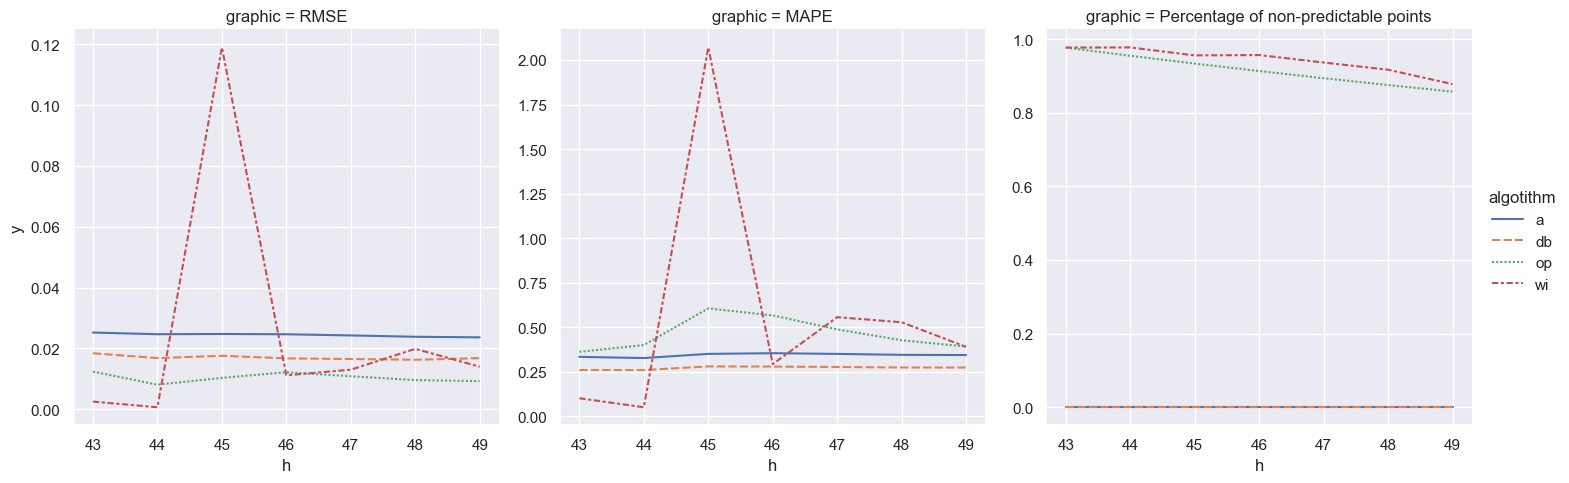

In [35]:
sns.relplot(
    data = df_up, kind = "line", col = 'graphic',
    x = 'h', y = 'y', hue='algotithm', style='algotithm', facet_kws=dict(sharey=False)
)

In [43]:
from scipy.interpolate import interp1d

In [ ]:
y1, py1 = pre1.predict(Y2[:50], 100, ForcedPredictionNPM(), 'wi', **kwargs)

In [64]:
x_p = []
y_p = []

for i in range(len(py1)):
    for j in range(len(py1[i])):
        if py1[i][j] < 1:
            x_p.append(x[i])
            y_p.append(py1[i][j])

<AxesSubplot:>

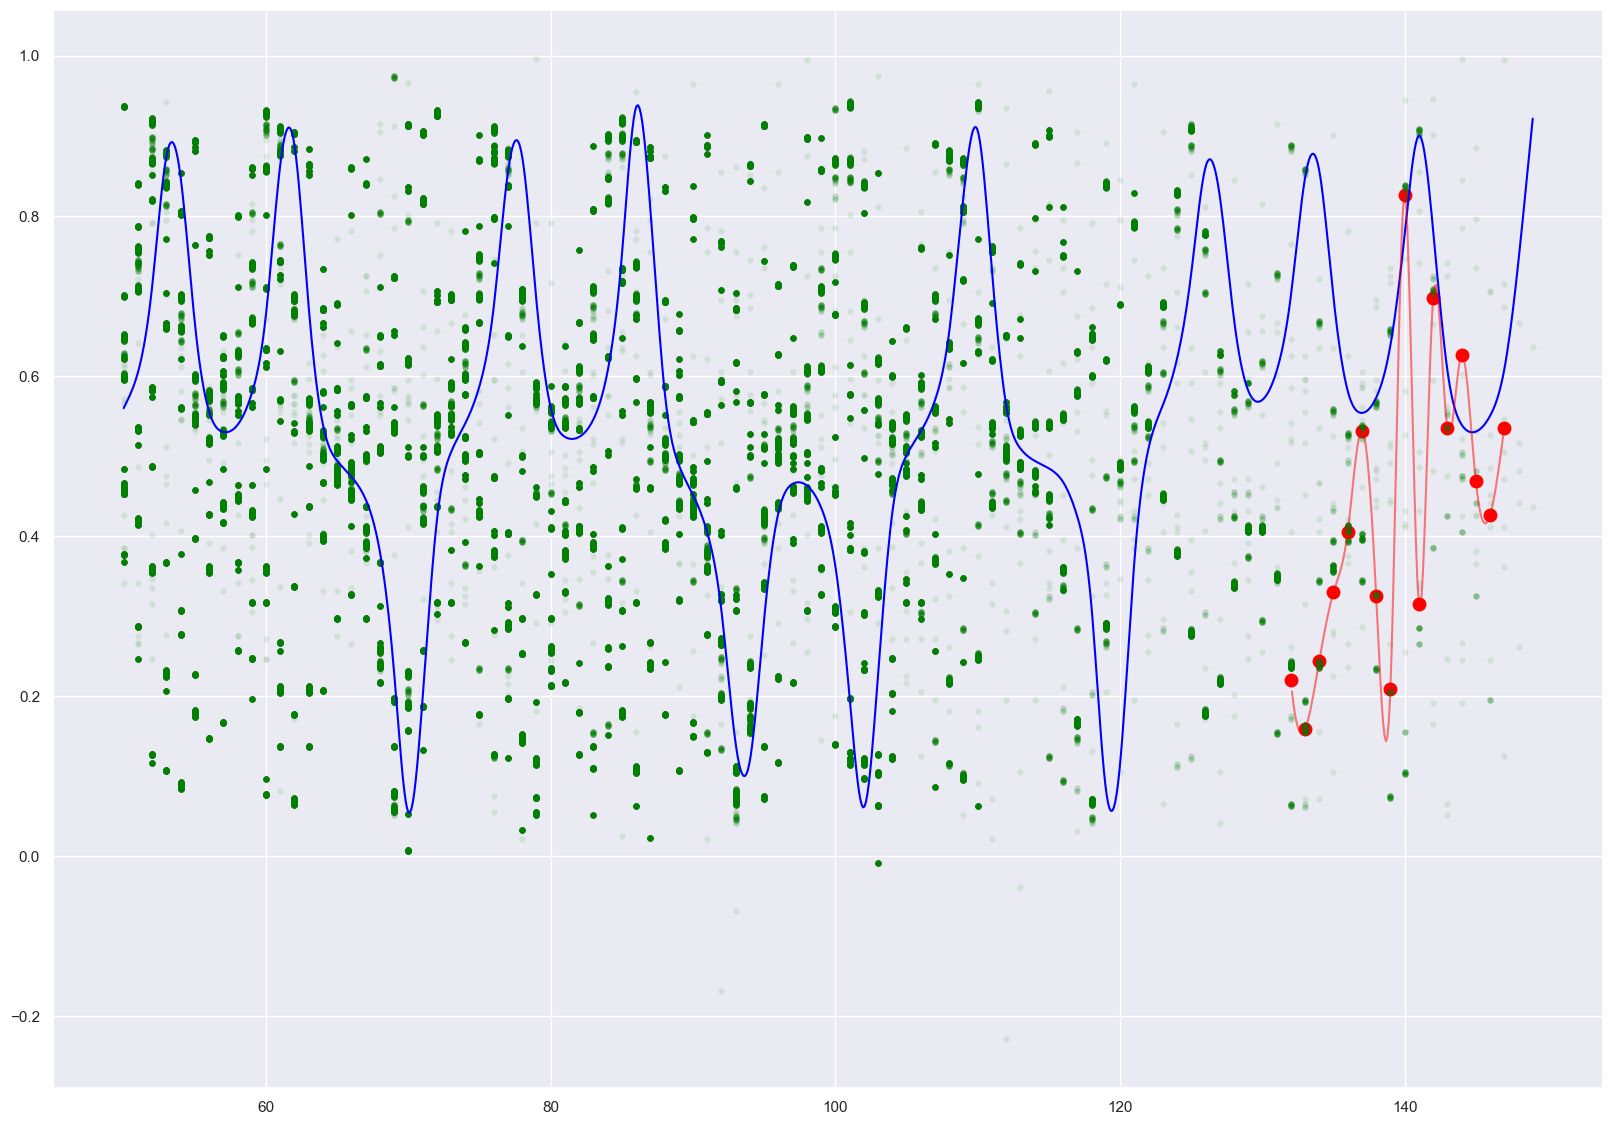

In [65]:
x = list(range(50, 150))
fig, ax = plt.subplots(1, 1, figsize=(20, 14))
x_1, y_1 = clean(x, y1)
sns.scatterplot(x=x_1, y=y_1, color='red', ax=ax, linewidth=0, s=100)

inter = interp1d(x=x, y=np.array(Y2)[x], kind='cubic', bounds_error=False)
xi = np.linspace(50, 150, 1000)
yi = inter(xi)
sns.lineplot(x=xi, y=yi, color='blue', ax=ax)
inter = interp1d(x=x_1, y=y_1, kind='cubic', bounds_error=False)
xi = np.linspace(50, 150, 1000)
yi = inter(xi)
sns.lineplot(x = xi, y=yi, color='red', ax=ax, alpha=0.5)

sns.scatterplot(x = x_p, y = y_p, color = 'green', s = 20, alpha = 0.1, linewidth = 0)

In [74]:
df_npm = pd.DataFrame(columns=['h', 'y', 'graphic', 'model'])
x = list(range(50, 150))

for i in tqdm(range(1, 50)):
    y1, py1 = pre1.predict(Y2[:50], i, ForcedPredictionNPM(), 'db', **kwargs)
    y2, py2 = pre1.predict(Y2[:50], i, RapidGrowthNPM(), 'db', **kwargs)
    y3, py3 = pre1.predict(Y2[:50], i, RapidGrowthDBSCANNPM(), 'db', **kwargs)

    x_1, y_1 = clean(x, y1)
    x_2, y_2 = clean(x, y2)
    x_3, y_3 = clean(x, y3)

    if len(y_1) > 0 and len(y_2) > 0 and len(y_3) > 0 and len(y_4) > 0:
        df_npm.loc[len(df_npm)] = [i, mean_squared_error(np.array(Y2[:200][x_1]), y_1), 'RMSE', 'ForcedPredictionNPM']
        df_npm.loc[len(df_npm)] = [i, mean_squared_error(np.array(Y2[:200][x_2]), y_2), 'RMSE', 'RapidGrowthNPM']
        df_npm.loc[len(df_npm)] = [i, mean_squared_error(np.array(Y2[:200][x_3]), y_3), 'RMSE', 'RapidGrowthDBSCANNPM']

        df_npm.loc[len(df_npm)] = [i, mean_absolute_percentage_error(np.array(Y2[:200][x_1]), y_1), 'MAPE', 'ForcedPredictionNPM']
        df_npm.loc[len(df_npm)] = [i, mean_absolute_percentage_error(np.array(Y2[:200][x_2]), y_2), 'MAPE', 'RapidGrowthNPM']
        df_npm.loc[len(df_npm)] = [i, mean_absolute_percentage_error(np.array(Y2[:200][x_3]), y_3), 'MAPE', 'RapidGrowthDBSCANNPM']

        df_npm.loc[len(df_npm)] = [i, (len(y1) - len(y_1)) / len(y1), 'Percentage of non-predictable points', 'ForcedPredictionNPM']
        df_npm.loc[len(df_npm)] = [i, (len(y2) - len(y_2)) / len(y2), 'Percentage of non-predictable points', 'RapidGrowthNPM']
        df_npm.loc[len(df_npm)] = [i, (len(y3) - len(y_3)) / len(y3), 'Percentage of non-predictable points', 'RapidGrowthDBSCANNPM']

100%|██████████| 49/49 [08:57<00:00, 10.97s/it]


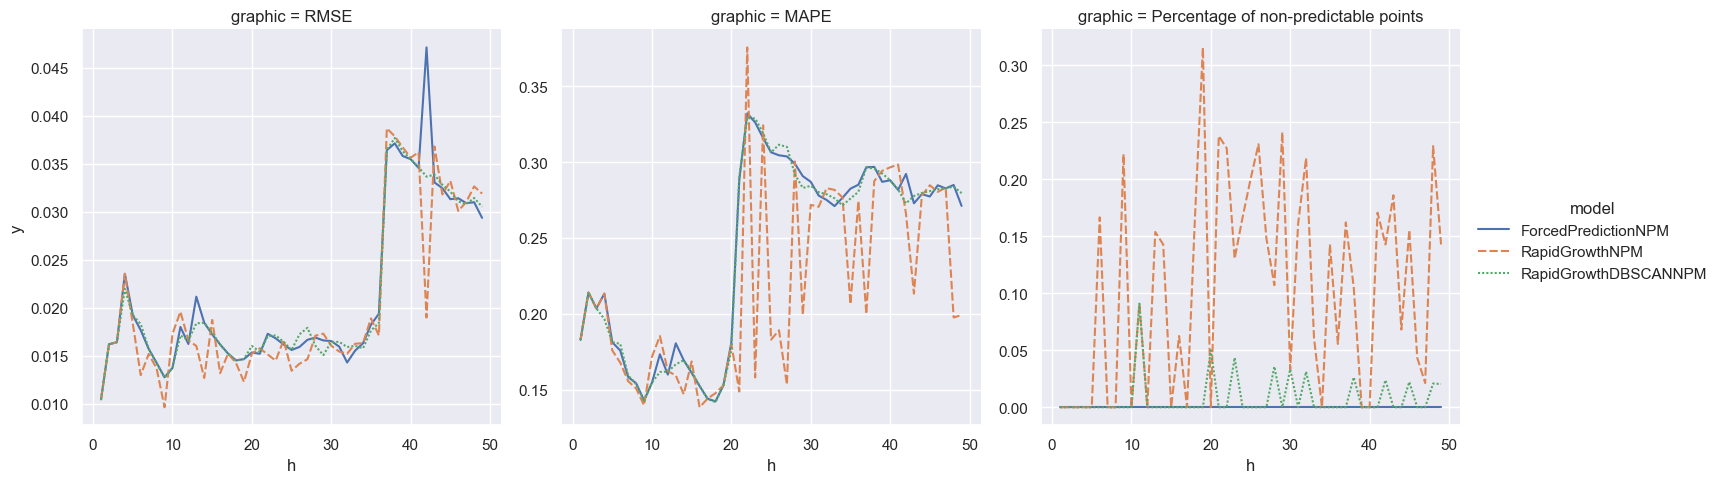

In [75]:
sns.relplot(
    data = df_npm, kind = "line", col = 'graphic',
    x = 'h', y = 'y', hue='model', style='model', facet_kws=dict(sharey=False)
)